In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# 自定义 MAPE 损失函数
class MAPE_Loss(nn.Module):
    def __init__(self):
        super(MAPE_Loss, self).__init__()

    def forward(self, y_pred, y_true):
        epsilon = 1e-8  # 避免除零
        return torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# 自定义 RMSE 损失函数
class RMSE_Loss(nn.Module):
    def __init__(self):
        super(RMSE_Loss, self).__init__()

    def forward(self, y_pred, y_true):
        return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

# 读取数据
data = pd.read_csv("../data/dataset.csv")

# 数据分割
data['target_class'] = pd.qcut(data['Cs'], q=10, labels=False)
X = data.drop(['Cs', 'target_class'], axis=1).values
y = data['Cs'].values
stratify_column = data['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=stratify_column)

# 数据标准化
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 将数据转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 创建 DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Epoch [10/5000], Loss: 32.7278
Epoch [20/5000], Loss: 26.4089
Epoch [30/5000], Loss: 21.5288
Epoch [40/5000], Loss: 18.1285
Epoch [50/5000], Loss: 15.7272
Epoch [60/5000], Loss: 14.5840
Epoch [70/5000], Loss: 13.7915
Epoch [80/5000], Loss: 13.3749
Epoch [90/5000], Loss: 12.8703
Epoch [100/5000], Loss: 12.3760
Epoch [110/5000], Loss: 12.1444
Epoch [120/5000], Loss: 11.7286
Epoch [130/5000], Loss: 11.2494
Epoch [140/5000], Loss: 11.3334
Epoch [150/5000], Loss: 10.8223
Epoch [160/5000], Loss: 10.2778
Epoch [170/5000], Loss: 10.6218
Epoch [180/5000], Loss: 10.0760
Epoch [190/5000], Loss: 10.2388
Epoch [200/5000], Loss: 9.4886
Epoch [210/5000], Loss: 9.5583
Epoch [220/5000], Loss: 9.9885
Epoch [230/5000], Loss: 10.1338
Epoch [240/5000], Loss: 9.1625
Epoch [250/5000], Loss: 9.1188
Epoch [260/5000], Loss: 8.9402
Epoch [270/5000], Loss: 9.7931
Epoch [280/5000], Loss: 9.3185
Epoch [290/5000], Loss: 9.2873
Epoch [300/5000], Loss: 8.6796
Epoch [310/5000], Loss: 9.4530
Epoch [320/5000], Loss: 9.10

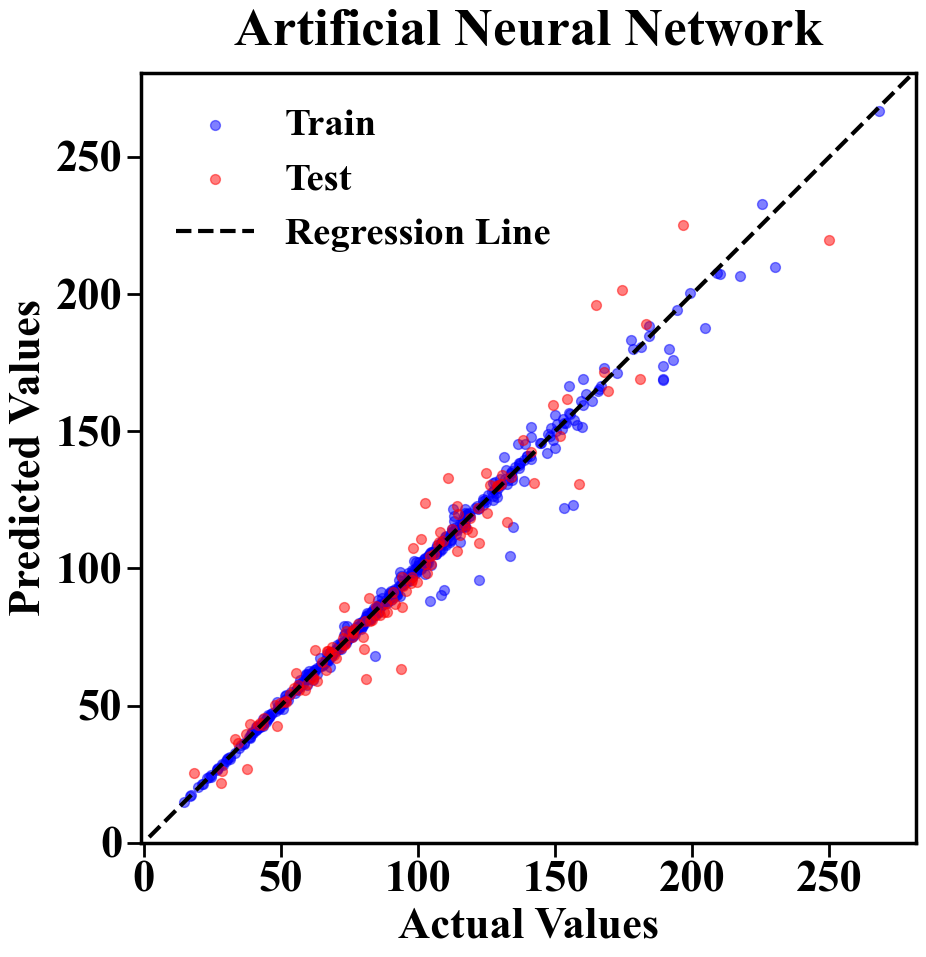

,model,R2_train,MAE_train,MAPE_train,RMSE_train,R2_test,MAE_test,MAPE_test,RMSE_test
0,ANN,0.987769,1.868901,1.701674,4.414943,0.951099,5.370097,5.837961,8.775968


In [4]:
from function import metrics_to_dataframe, plot_actual_vs_predicted


class ANN(nn.Module):
    def __init__(self, input_dim):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 12)
        self.layer2 = nn.Linear(12, 90)
        self.layer3 = nn.Linear(90, 90)
        self.layer4 = nn.Linear(90, 60)
        self.layer5 = nn.Linear(60, 70)
        self.layer6 = nn.Linear(70, 30)
        self.output = nn.Linear(30, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = torch.relu(self.layer5(x))
        x = torch.relu(self.layer6(x))
        x = self.output(x)
        return x

# 初始化模型
input_dim = X_train_scaled.shape[1]
model = ANN(input_dim)

# 选择损失函数 (可以选择 MAPE 或 RMSE)
loss_function = MAPE_Loss()
# loss_function = RMSE_Loss()  # 或者使用 MAPE_Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 5000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_function(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # 每 10 个 epoch 打印一次平均损失
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# 评估模型
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor).numpy()
    y_test_pred = model(X_test_tensor).numpy()
    
# 保存模型
torch.save(model.state_dict(), "ann_model.pth")

# 绘制实际 vs 预测图
plot_actual_vs_predicted(y_train, y_train_pred, y_test, y_test_pred, 'Artificial Neural Network', 'ann.png')

# 计算并显示评估指标
ann_metrics = metrics_to_dataframe(y_train, y_train_pred, y_test, y_test_pred, 'ANN')
ann_metrics